In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 79993952.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


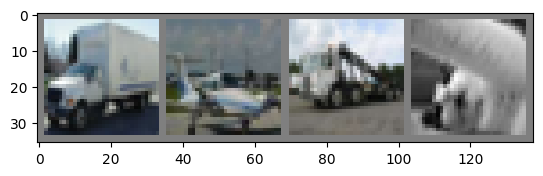

truck plane truck cat  


In [5]:
# sampling CIFAR10 images
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# sample images from training dataset
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images and labels
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# defining neural net structure
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
import torch.optim as optim

# loss function and optimization function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
for epoch in range(2):  # 2 loops over dataset

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # initialize gradiants to zero
        optimizer.zero_grad()

        # forward, backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # batch size=4, so 12500 batch calls for training data
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.212
[1,  4000] loss: 1.885
[1,  6000] loss: 1.687
[1,  8000] loss: 1.580
[1, 10000] loss: 1.549
[1, 12000] loss: 1.506
[2,  2000] loss: 1.427
[2,  4000] loss: 1.394
[2,  6000] loss: 1.372
[2,  8000] loss: 1.332
[2, 10000] loss: 1.325
[2, 12000] loss: 1.303
Finished Training


In [14]:
# saving weights (optional)
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

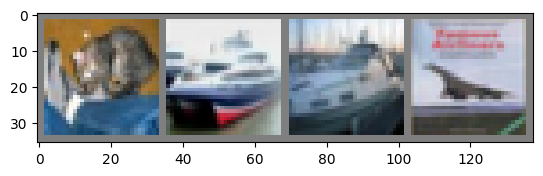

GroundTruth:  cat   ship  ship  plane


In [27]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images from test dataset
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [28]:
# loading weights (optional)
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [29]:
# model run on sampled test images
outputs = net(images)

In [30]:
# choose the label with highest likelihood as prediction
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


In [33]:
correct = 0
total = 0
# accuracy testing
with torch.no_grad(): # testing, no gradient update
    for data in testloader:
        images, labels = data
        # only run forward
        outputs = net(images)
        # the highest energy class = prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


In [34]:
# counting correct predictions per class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# testing, no gradient update
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # update correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 69.5 %
Accuracy for class: car   is 57.1 %
Accuracy for class: bird  is 31.4 %
Accuracy for class: cat   is 31.5 %
Accuracy for class: deer  is 54.1 %
Accuracy for class: dog   is 58.6 %
Accuracy for class: frog  is 70.8 %
Accuracy for class: horse is 55.0 %
Accuracy for class: ship  is 67.0 %
Accuracy for class: truck is 67.3 %


In [38]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cpu


In [36]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [37]:
inputs, labels = data[0].to(device), data[1].to(device)